## **Time Series ForeCasting**

Time Series Forecasting is the process of predicting future values based on previously observed values in a time series data. A time series is a sequence of data points recorded over a period of time at regular intervals, such as daily stock prices, monthly sales, or yearly weather temperatures. Forecasting involves using past data to model patterns like trends, seasonality, or cyclic behavior to predict future values.

In [678]:
# importing libraries:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from pandas.plotting import autocorrelation_plot
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score,root_mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [679]:
# READ CSV FILE
df = pd.read_csv('Walmart_Sales.csv')
df

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106
...,...,...,...,...,...,...,...,...
6430,45,28-09-2012,713173.95,0,64.88,3.997,192.013558,8.684
6431,45,05-10-2012,733455.07,0,64.89,3.985,192.170412,8.667
6432,45,12-10-2012,734464.36,0,54.47,4.000,192.327265,8.667
6433,45,19-10-2012,718125.53,0,56.47,3.969,192.330854,8.667


# **Check the datatype of all features of the dataset on walmart.**

In [680]:
df.dtypes

Store             int64
Date             object
Weekly_Sales    float64
Holiday_Flag      int64
Temperature     float64
Fuel_Price      float64
CPI             float64
Unemployment    float64
dtype: object

In [681]:
#Check if there is any missing values in the Dataset.
df.isnull().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

## **Plot the features data for checking pattterns in it.**

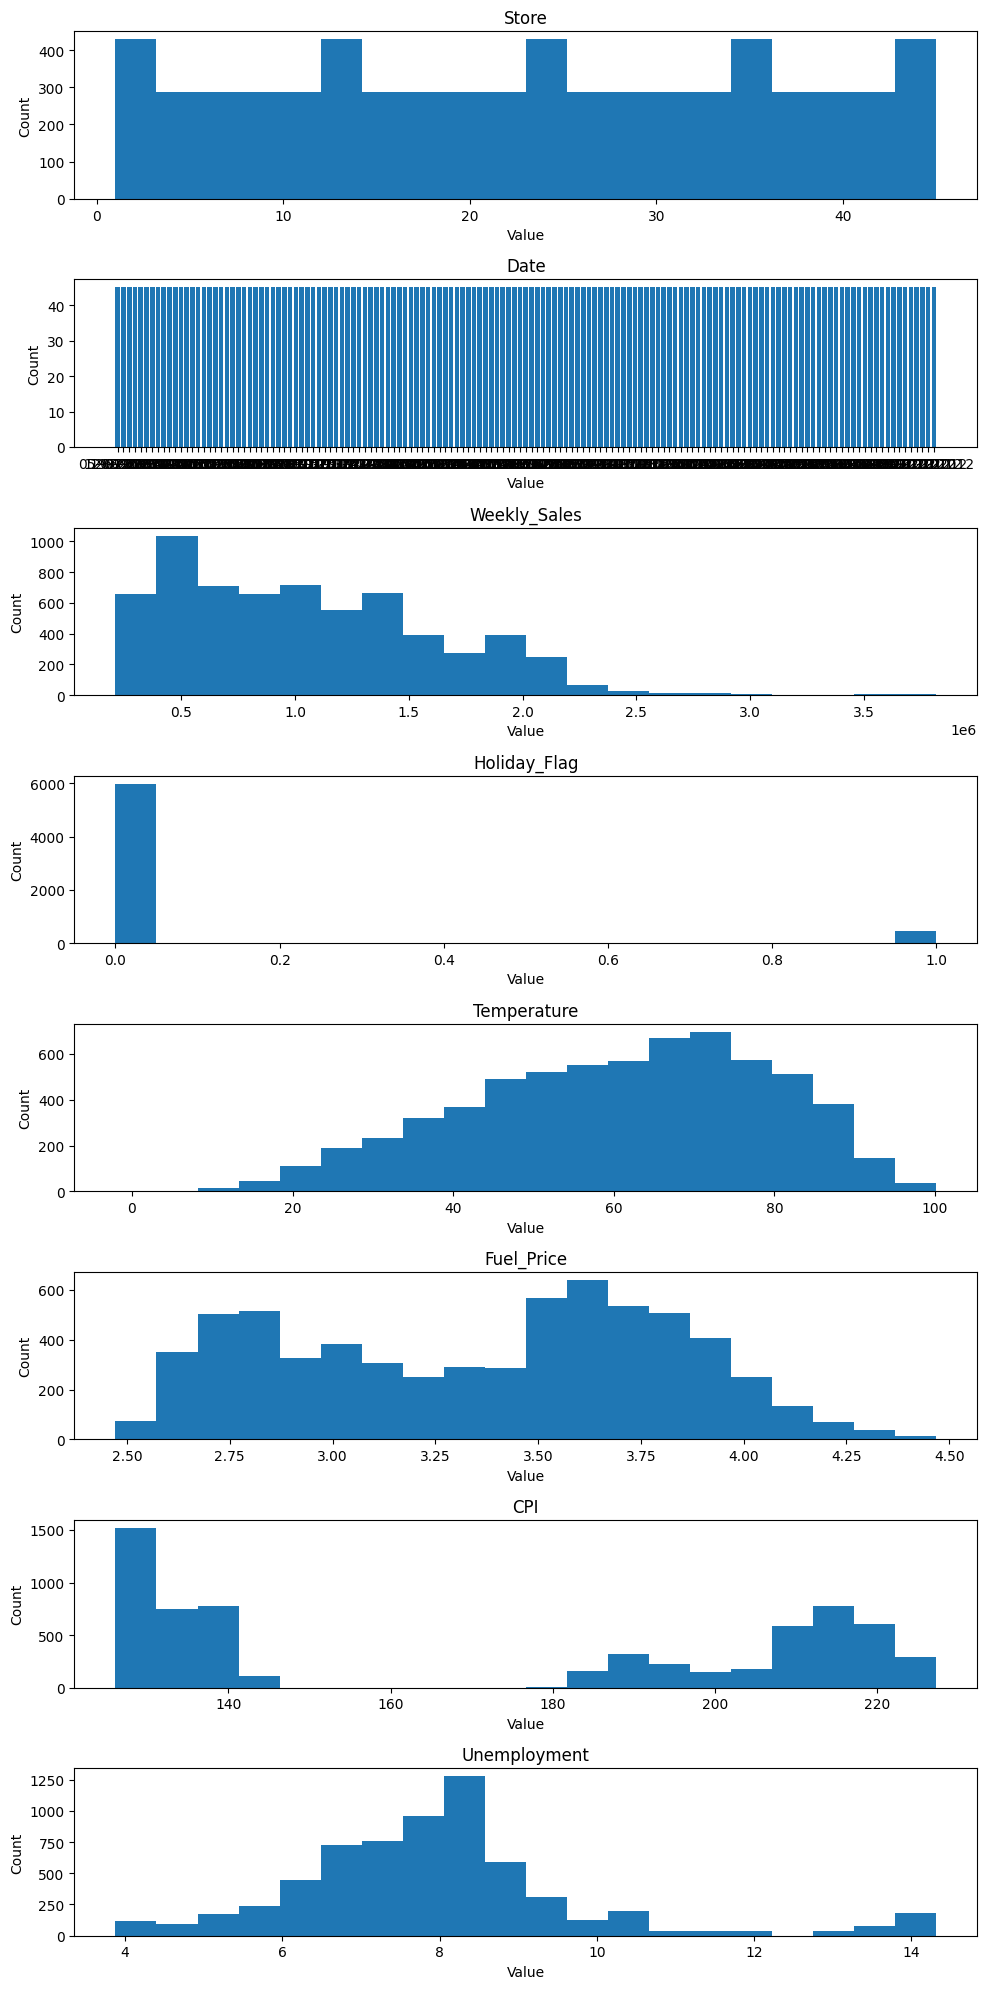

In [682]:
# Assuming 'df' is your DataFrame with features as columns
features = df.columns

# Create a figure with subplots
fig, axs = plt.subplots(nrows = len(features), figsize=(10, 20))

# Loop through each feature and create a bar plot or histogram depending on the data type
for i, feature in enumerate(features):
    # Check if the feature is numeric
    if df[feature].dtype == 'object':
        # Use bar plot for categorical features
        axs[i].bar(df[feature].value_counts().index, df[feature].value_counts())
    else:
        # Use histogram for continuous numerical features
        axs[i].hist(df[feature], bins=20)  # Adjust the number of bins as necessary

    # Set titles and labels
    axs[i].set_title(feature)
    axs[i].set_xlabel('Value')
    axs[i].set_ylabel('Count')

# Adjust layout to avoid overlap
fig.tight_layout()

# Show the plot
plt.show()

## **Feature Engineerinig**

In [683]:
df['Date'] = pd.to_datetime(df['Date'], format = 'mixed', dayfirst = True)
df['Date'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 6435 entries, 0 to 6434
Series name: Date
Non-Null Count  Dtype         
--------------  -----         
6435 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 50.4 KB


In [684]:
df['day'] = df['Date'].dt.day 
df['month'] = df['Date'].dt.month
df['year'] = df['Date'].dt.year

df[['day', 'month', 'year']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   day     6435 non-null   int32
 1   month   6435 non-null   int32
 2   year    6435 non-null   int32
dtypes: int32(3)
memory usage: 75.5 KB


In [685]:
def to_season(month: int) -> str:
    
    if month in (12, 1, 2):
        return 'Winter'
    elif month in (3, 4, 5):
        return 'Spring'
    elif month in (6, 7, 8):
        return 'Summer'
    else:
        return 'Fall'

df['season'] = df['month'].apply(lambda x: to_season(x))    
df['season'].value_counts()

season
Summer    1800
Spring    1755
Fall      1530
Winter    1350
Name: count, dtype: int64

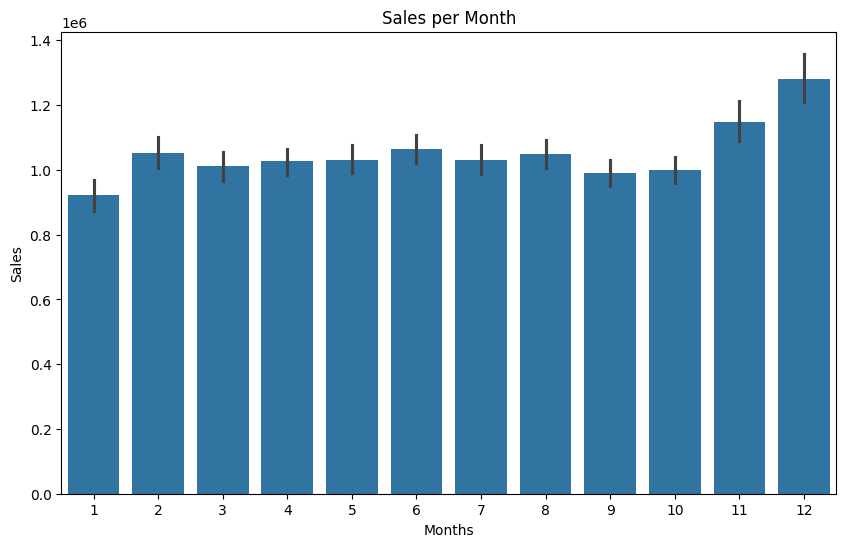

In [686]:
#MONTHLY w.r.t SALES
plt.figure(figsize=(10,6))
sns.barplot(data = df, x = 'month', y = 'Weekly_Sales')
plt.xlabel('Months')
plt.ylabel('Sales')
plt.title('Sales per Month')
plt.show()

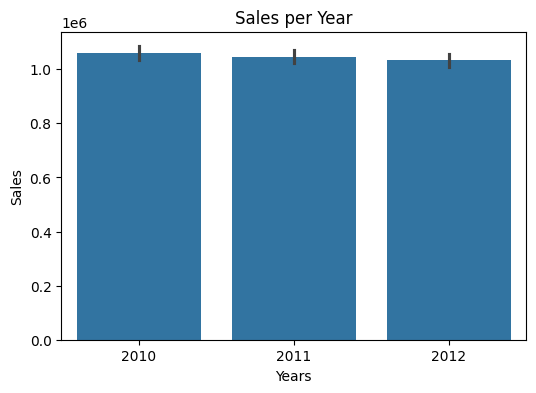

In [687]:
#YEARLY w.r.t SALES
plt.figure(figsize=(6,4))
sns.barplot(data = df, x = 'year', y = 'Weekly_Sales')
plt.xlabel('Years')
plt.ylabel('Sales')
plt.title('Sales per Year')
plt.show()

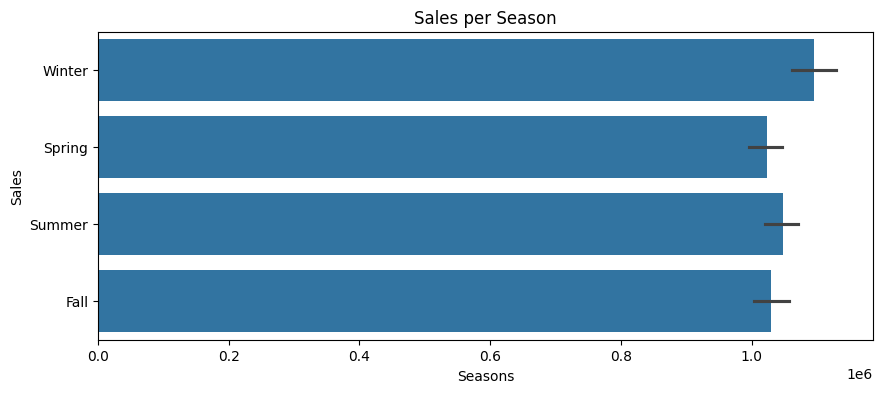

In [688]:
# Seasonal Data w.r.t Weekly_Sales

plt.figure(figsize=(10,4))
sns.barplot(data = df, y = 'season', x = 'Weekly_Sales', orient = 'h')
plt.xlabel('Seasons')
plt.ylabel('Sales')
plt.title('Sales per Season')
plt.show()

## **Sales by Holiday**

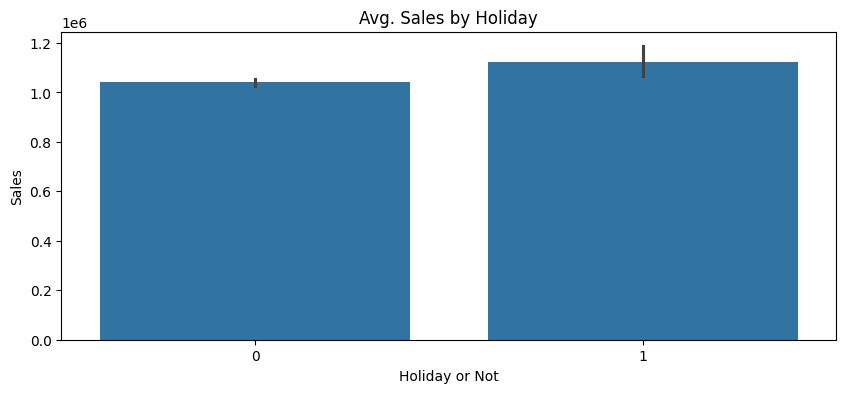

In [689]:
plt.figure(figsize = (10,4))
sns.barplot(data = df, x = 'Holiday_Flag', y = 'Weekly_Sales', estimator = 'mean')
plt.xlabel('Holiday or Not')
plt.ylabel('Sales')
plt.title('Avg. Sales by Holiday')
plt.show()


In [690]:
plot_data = df.pivot_table(index = 'year', columns = 'Holiday_Flag', values = 'Weekly_Sales', aggfunc = 'mean')
plot_data

Holiday_Flag,0,1
year,,
2010,1.054880e+06,1.112359e+06
2011,1.037715e+06,1.148530e+06
2012,1.030782e+06,1.092661e+06


<Axes: xlabel='Avg of Sales'>

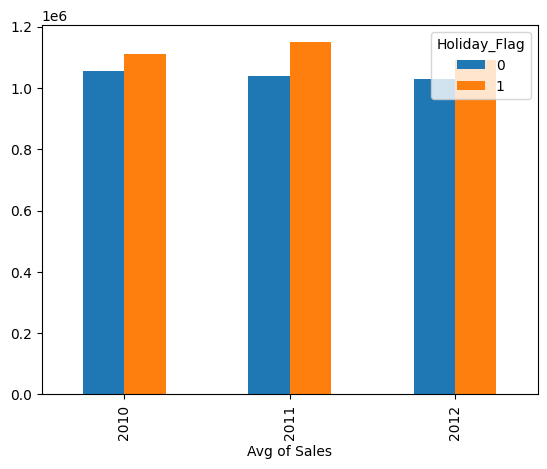

In [691]:
plot_data.plot(kind = 'bar', xlabel = 'Avg of Sales')

In [692]:
plot_data = df.pivot_table(index = 'month', columns = 'Holiday_Flag', values = 'Weekly_Sales', aggfunc = 'mean')
plot_data

Holiday_Flag,0,1
month,,
1,9.238846e+05,NaN
2,1.044557e+06,1.079128e+06
3,1.013309e+06,NaN
4,1.026762e+06,NaN
5,1.031714e+06,NaN
6,1.064325e+06,NaN
7,1.031748e+06,NaN
8,1.048017e+06,NaN
9,9.734078e+05,1.042427e+06


<Axes: xlabel='Avg. of Sales'>

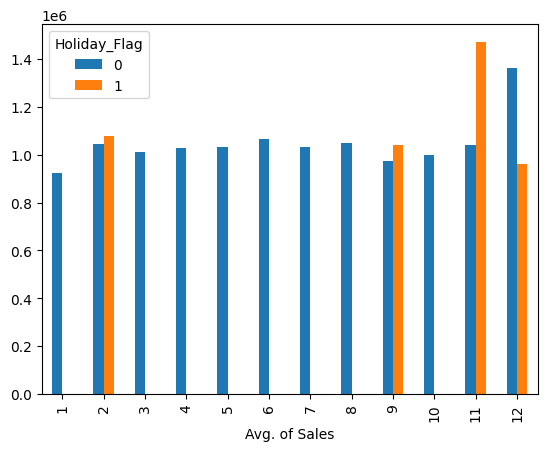

In [693]:
plot_data.plot(kind = 'bar', xlabel = 'Avg. of Sales')

In [694]:
df.columns

Index(['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment', 'day', 'month', 'year', 'season'],
      dtype='object')

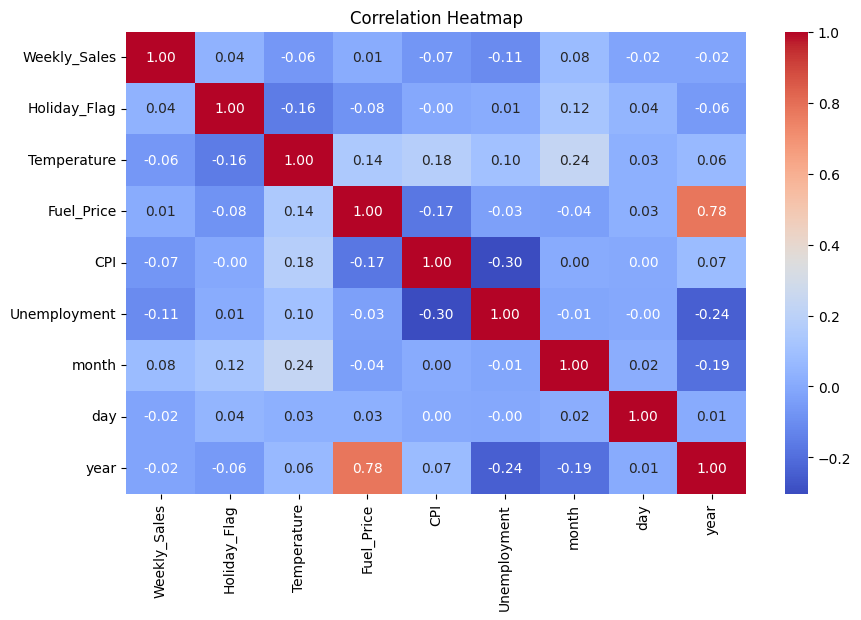

In [695]:
corr_matrix = df[['Weekly_Sales', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'month', 'day', 'year']].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [696]:
corr_matrix

,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,month,day,year
Weekly_Sales,1.000000,0.036891,-0.063810,0.009464,-0.072634,-0.106176,0.076143,-0.017409,-0.018378
Holiday_Flag,0.036891,1.000000,-0.155091,-0.078347,-0.002162,0.010960,0.122996,0.044526,-0.056783
Temperature,-0.063810,-0.155091,1.000000,0.144982,0.176888,0.101158,0.235862,0.026973,0.064269
Fuel_Price,0.009464,-0.078347,0.144982,1.000000,-0.170642,-0.034684,-0.042156,0.028073,0.779470
CPI,-0.072634,-0.002162,0.176888,-0.170642,1.000000,-0.302020,0.004980,0.002684,0.074796
Unemployment,-0.106176,0.010960,0.101158,-0.034684,-0.302020,1.000000,-0.012746,-0.004233,-0.241813
month,0.076143,0.122996,0.235862,-0.042156,0.004980,-0.012746,1.000000,0.015192,-0.194465
day,-0.017409,0.044526,0.026973,0.028073,0.002684,-0.004233,0.015192,1.000000,0.006406
year,-0.018378,-0.056783,0.064269,0.779470,0.074796,-0.241813,-0.194465,0.006406,1.000000


## **Variation of sales across stores.**

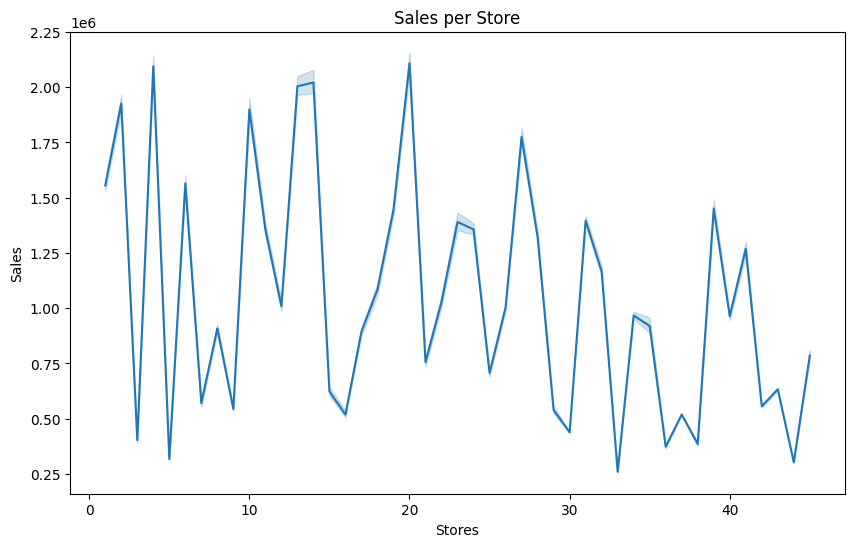

In [697]:
plt.figure(figsize=(10,6))
sns.lineplot(data = df, x = 'Store', y = 'Weekly_Sales')
plt.xlabel('Stores')
plt.ylabel('Sales')
plt.title('Sales per Store')
plt.show()

# **Peak sales periods during the year.**

In [698]:
plot_data = df.pivot_table(index = 'year', columns = 'season', values = 'Weekly_Sales', aggfunc = 'sum')
plot_data

season,Fall,Spring,Summer,Winter
year,,,,
2010,5.972831e+08,6.000431e+08,6.124664e+08,4.790935e+08
2011,6.142714e+08,5.875311e+08,6.082841e+08,6.381134e+08
2012,3.650072e+08,6.091970e+08,6.649705e+08,3.609581e+08


<Axes: xlabel='year', ylabel='Sum of Sales'>

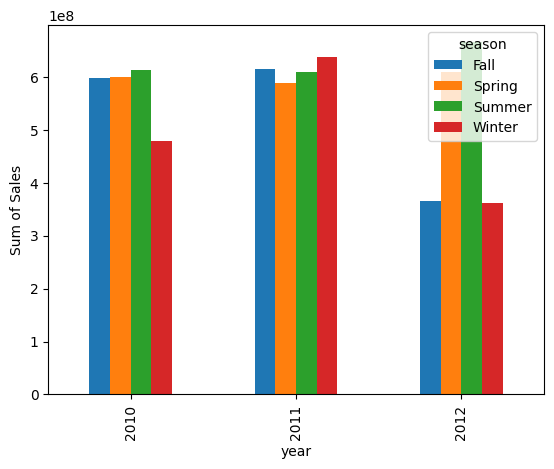

In [699]:
plot_data.plot(kind = 'bar', ylabel = 'Sum of Sales')

In [700]:
# SALES w.r.t Monthly_Data 
plot_data = df.pivot_table(index = 'year', columns = 'month', values = 'Weekly_Sales', aggfunc = 'sum')
plot_data

month,1,2,3,4,5,6,7,8,9,10,11,12
year,,,,,,,,,,,,
2010,NaN,1.903330e+08,1.819198e+08,2.314124e+08,1.867109e+08,1.922462e+08,2.325801e+08,1.876401e+08,1.772679e+08,2.171618e+08,2.028534e+08,2.887605e+08
2011,1.637040e+08,1.863313e+08,1.793564e+08,2.265265e+08,1.816482e+08,1.897734e+08,2.299114e+08,1.885993e+08,2.208477e+08,1.832613e+08,2.101624e+08,2.880781e+08
2012,1.688945e+08,1.920636e+08,2.315097e+08,1.889209e+08,1.887665e+08,2.406103e+08,1.875095e+08,2.368508e+08,1.806455e+08,1.843617e+08,NaN,NaN


<Axes: xlabel='year', ylabel='Sum of Sales'>

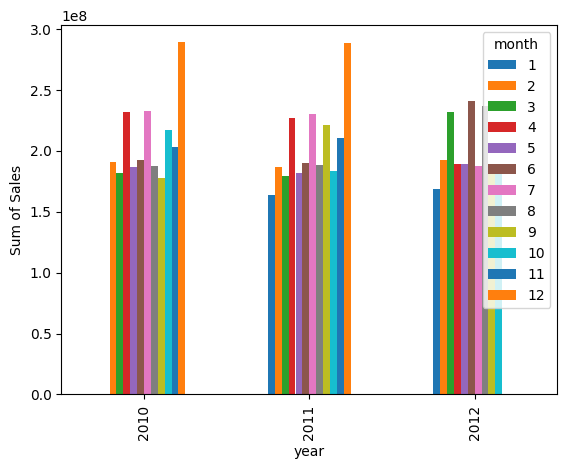

In [701]:
plot_data.plot(kind = 'bar', ylabel = 'Sum of Sales')

## **Outliers Detection**

In [702]:
df['z_score'] = np.abs(stats.zscore(df['Weekly_Sales']))
df.shape

(6435, 13)

In [703]:
thresh = 3
df = df[df['z_score'] < thresh]
df = df.drop('z_score', axis = 1)
df.shape

(6404, 12)

## **Encoding**

In [704]:
encoder = OneHotEncoder()
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
categorical_columns

['season']

In [705]:
data_encoded = encoder.fit_transform(df[categorical_columns]).toarray()
columns = encoder.get_feature_names_out(categorical_columns)
df_encoded = pd.DataFrame(data_encoded, columns = columns)
df_encoded

,season_Fall,season_Spring,season_Summer,season_Winter
0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,1.0
4,0.0,1.0,0.0,0.0
...,...,...,...,...
6399,1.0,0.0,0.0,0.0
6400,1.0,0.0,0.0,0.0
6401,1.0,0.0,0.0,0.0
6402,1.0,0.0,0.0,0.0


In [706]:
df_clean_encoded = pd.concat([df, df_encoded], axis = 1)
df_clean_encoded = df_clean_encoded.drop('season', axis = 1)
df_clean_encoded.dropna(inplace = True)

In [707]:
#check the datatype of the columns
df_clean_encoded.dtypes

Store                   float64
Date             datetime64[ns]
Weekly_Sales            float64
Holiday_Flag            float64
Temperature             float64
Fuel_Price              float64
CPI                     float64
Unemployment            float64
day                     float64
month                   float64
year                    float64
season_Fall             float64
season_Spring           float64
season_Summer           float64
season_Winter           float64
dtype: object

In [708]:
#drop the column 'date' from the dataframe
df_clean_encoded = df_clean_encoded.drop('Date', axis = 1)
df_clean_encoded.shape

(6373, 14)

In [709]:
scaler = StandardScaler()
columns = df_clean_encoded.columns
data_scaled = scaler.fit_transform(df_clean_encoded)
df_scaled = pd.DataFrame(data_scaled, columns = columns)
df_scaled

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,day,month,year,season_Fall,season_Spring,season_Summer,season_Winter
0,-1.697261,1.106336,-0.272326,-0.998634,-1.709338,1.003215,0.057012,-1.215034,-1.368621,-1.209504,-0.559892,-0.613562,-0.625202,1.958407
1,-1.697261,1.103168,3.672069,-1.204641,-1.761577,1.006913,0.057012,-0.415968,-1.368621,-1.209504,-0.559892,-0.613562,-0.625202,1.958407
2,-1.697261,1.048368,-0.272326,-1.127659,-1.835582,1.008104,0.057012,0.383099,-1.368621,-1.209504,-0.559892,-0.613562,-0.625202,1.958407
3,-1.697261,0.678808,-0.272326,-0.764437,-1.733281,1.008878,0.057012,1.182166,-1.368621,-1.209504,-0.559892,-0.613562,-0.625202,1.958407
4,-1.697261,0.943915,-0.272326,-0.771484,-1.593977,1.009651,0.057012,-1.215034,-1.058971,-1.209504,-0.559892,1.629828,-0.625202,-0.510619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6368,1.705707,-0.521136,-0.272326,-0.968817,0.830778,0.468325,0.225934,0.953861,-1.368621,1.303346,1.786059,-0.613562,-0.625202,-0.510619
6369,1.705707,-0.466800,-0.272326,-1.039835,0.998378,0.472497,0.225934,-1.557492,-1.058971,1.303346,1.786059,-0.613562,-0.625202,-0.510619
6370,1.705707,-0.477448,-0.272326,-0.824612,1.068030,0.476669,0.225934,-0.758425,-1.058971,1.303346,1.786059,-0.613562,-0.625202,-0.510619
6371,1.705707,-0.456669,-0.272326,-0.551382,1.098502,0.479863,0.225934,0.040642,-1.058971,1.303346,1.786059,-0.613562,-0.625202,-0.510619


<Axes: >

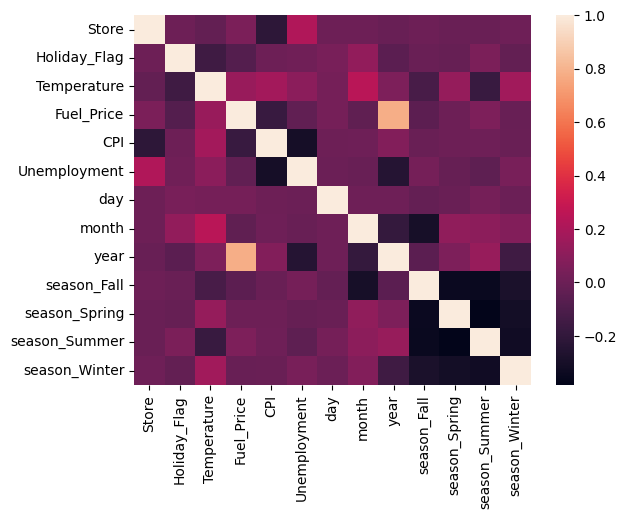

In [710]:
sns.heatmap(data = df_scaled.drop('Weekly_Sales', axis = 1).corr())

## **Initializing X and y variables**

`Weekly_Sales`: This is a common choice for the target feature if you are predicting sales figures. For example, if you want to forecast the sales of a particular store for the upcoming weeks or months, Weekly_Sales would be your target feature.

### **Regression Tasks:**

Weekly_Sales is a `continuous numerical feature`, which makes it suitable for regression tasks. You would use historical sales data to predict future sales values.

`Example Models`: Linear Regression, ARIMA, Random Forest Regressor, etc.

In [711]:
from sklearn.decomposition import PCA

df_pca = df_scaled.drop('Weekly_Sales', axis = 1)

      Store  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price       CPI  \
0 -1.697261      1.106336     -0.272326    -0.998634   -1.709338  1.003215   
1 -1.697261      1.103168      3.672069    -1.204641   -1.761577  1.006913   
2 -1.697261      1.048368     -0.272326    -1.127659   -1.835582  1.008104   
3 -1.697261      0.678808     -0.272326    -0.764437   -1.733281  1.008878   
4 -1.697261      0.943915     -0.272326    -0.771484   -1.593977  1.009651   
5 -1.697261      0.733288     -0.272326    -0.159427   -1.502559  1.010425   
6 -1.697261      0.793543     -0.272326    -0.333448   -1.387198  1.006240   
7 -1.697261      0.669128     -0.272326    -0.503133   -1.361079  1.001228   
8 -1.697261      1.017304     -0.272326     0.083445   -1.389375  0.996217   
9 -1.697261      0.926760     -0.272326     0.278067   -1.278367  0.991205   

   Unemployment       day     month      year  season_Fall  season_Spring  \
0      0.057012 -1.215034 -1.368621 -1.209504    -0.559892      

np.float64(0.9999999999999998)

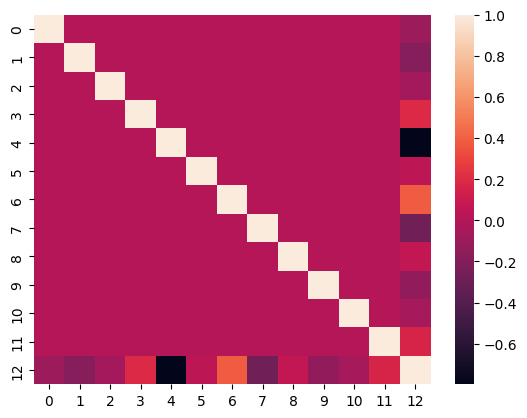

In [717]:
pca = PCA()
print(df_scaled.head(10))
reduced_data = pca.fit_transform(df_pca)
print(reduced_data)
df_reduced=pd.DataFrame(reduced_data)
sns.heatmap(data = df_reduced.corr())

explained_variance = pca.explained_variance_ratio_
explained_variance.sum()

In [718]:
X = df_reduced
Y = df_scaled['Weekly_Sales']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 69)

In [714]:
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Create a dictionary of models
models = {
    'LinearRegression': LinearRegression(),
    'SVR': SVR(),
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'RandomForestRegressor': RandomForestRegressor(),
    'KNeighborsRegressor': KNeighborsRegressor(),
    'GradientBoostingRegressor': GradientBoostingRegressor(),
    'XGBRegressor': XGBRegressor()   
}

# Train each model and evaluate
model_scores = []

for name, model in models.items():
    model.fit(X_train, y_train)  # Fit the model
    y_pred = model.predict(X_test)  # Predict on the test set
    metric = r2_score(y_test, y_pred)  # Calculate R2 score
    model_scores.append((name, metric))
    
    # Print the performance metric
    print(f"{name} R2: {metric:.2f}")
    print('\n')

# Select the best model based on R2 score
sorted_models = sorted(model_scores, key=lambda x: x[1], reverse=True)
for model in sorted_models:
    print(f'R_squared Score: {model[0]} is {model[1]:.2f}')

LinearRegression R2: 0.13


SVR R2: 0.29


DecisionTreeRegressor R2: 0.31


RandomForestRegressor R2: 0.64


KNeighborsRegressor R2: 0.32


GradientBoostingRegressor R2: 0.36


XGBRegressor R2: 0.59


R_squared Score: RandomForestRegressor is 0.64
R_squared Score: XGBRegressor is 0.59
R_squared Score: GradientBoostingRegressor is 0.36
R_squared Score: KNeighborsRegressor is 0.32
R_squared Score: DecisionTreeRegressor is 0.31
R_squared Score: SVR is 0.29
R_squared Score: LinearRegression is 0.13


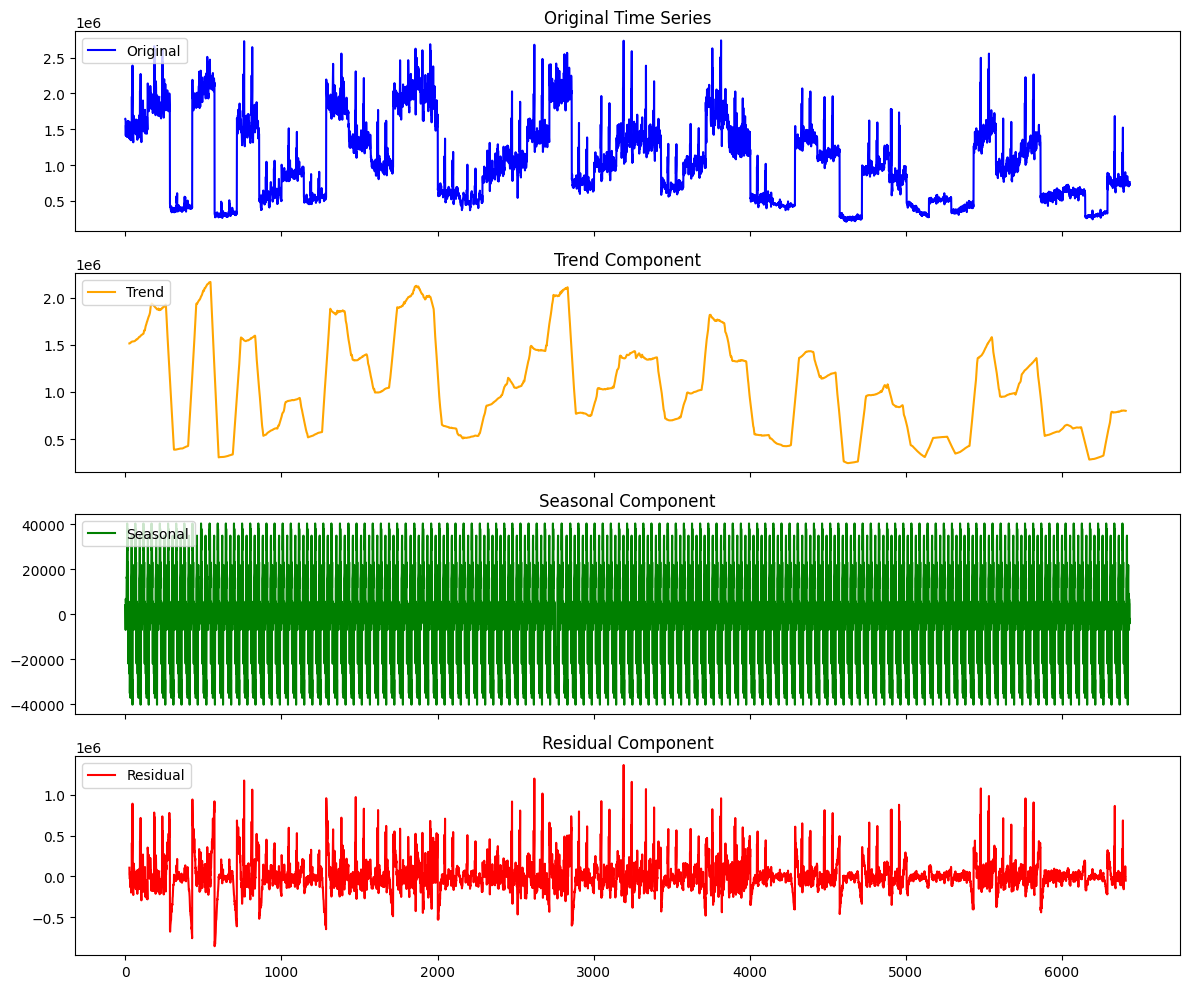

In [715]:
from statsmodels.tsa.seasonal import seasonal_decompose

ts = df['Weekly_Sales']

# Perform the decomposition
decomposition = seasonal_decompose(ts, model='additive', period=52)  # 'period' is set for weekly seasonality

# Plot the decomposition components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, figsize=(12, 10), sharex=True)

# Original Time Series
ax1.plot(ts, label='Original', color='blue')
ax1.set_title('Original Time Series')
ax1.legend(loc='upper left')

# Trend Component
ax2.plot(decomposition.trend, label='Trend', color='orange')
ax2.set_title('Trend Component')
ax2.legend(loc='upper left')

# Seasonal Component
ax3.plot(decomposition.seasonal, label='Seasonal', color='green')
ax3.set_title('Seasonal Component')
ax3.legend(loc='upper left')

# Residual Component
ax4.plot(decomposition.resid, label='Residual', color='red')
ax4.set_title('Residual Component')
ax4.legend(loc='upper left')

# Adjust layout
fig.tight_layout()

# Show the plots
plt.show()